In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [90]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28*28)
x_test = x_test.reshape(x_test.shape[0], 28*28)

In [3]:
def get_data(path):
    data = pd.read_csv(path, index_col=0)

    cols = list(data.columns)
    target = cols.pop()

    X = data[cols].copy()
    y = data[target].copy()

    y = LabelEncoder().fit_transform(y)

    return np.array(X), np.array(y)

X, y = get_data(r"C:\Users\12482\Desktop\articles\nn_from_scratch\iris.csv")

In [66]:
class DenseLayer:
    def __init__(self, neurons):
        self.neurons = neurons
        
    def relu(self, inputs):
        return np.maximum(0, inputs)

    def softmax(self, inputs):
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
    
    def relu_derivative(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ
    
    def forward(self, inputs, weights, bias, activation):
        Z_curr = np.dot(inputs, weights.T) + bias
        
        if activation == 'relu':
            A_curr = self.relu(inputs=Z_curr)
        elif activation == 'softmax':
            A_curr = self.softmax(inputs=Z_curr)
            
        return A_curr, Z_curr
    
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        if activation == 'softmax':
            dW = np.dot(A_prev.T, dA_curr)
            db = np.sum(dA_curr, axis=0, keepdims=True)
            dA = np.dot(dA_curr, W_curr) 
        else:
            dZ = self.relu_derivative(dA_curr, Z_curr)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, W_curr)
            
        return dA, dW, db

class Network:
    def __init__(self):
        self.network = [] ## layers
        self.architecture = [] ## mapping input neurons --> output neurons
        self.params = [] ## W, b
        self.memory = [] ## Z, A
        self.gradients = [] ## dW, db
        
    def add(self, layer):
        self.network.append(layer)
            
    def _compile(self, data):
        for idx, layer in enumerate(self.network):
            if idx == 0:
                self.architecture.append({'input_dim':data.shape[1], 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            elif idx > 0 and idx < len(self.network)-1:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            else:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'softmax'})
        return self
    
    def _init_weights(self, data):
        self._compile(data)
        
        np.random.seed(99)
        
        for i in range(len(self.architecture)):
            self.params.append({
                'W':np.random.uniform(low=-1, high=1, 
                  size=(self.architecture[i]['output_dim'], 
                        self.architecture[i]['input_dim'])),
                'b':np.zeros((1, self.architecture[i]['output_dim']))})
        
        return self
    
    def _forwardprop(self, data):
        A_curr = data
        
        for i in range(len(self.params)):
            A_prev = A_curr
            A_curr, Z_curr = self.network[i].forward(inputs=A_prev, weights=self.params[i]['W'], 
                                           bias=self.params[i]['b'], activation=self.architecture[i]['activation'])
            
            self.memory.append({'inputs':A_prev, 'Z':Z_curr})
            
        return A_curr
    
    def _backprop(self, predicted, actual):
        num_samples = len(actual)
        
        ## compute the gradient on predictions
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples
        
        dA_prev = dscores
        
        for idx, layer in reversed(list(enumerate(self.network))):
            dA_curr = dA_prev
            
            A_prev = self.memory[idx]['inputs']
            Z_curr = self.memory[idx]['Z']
            W_curr = self.params[idx]['W']
            
            activation = self.architecture[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr, Z_curr, A_prev, activation)

            self.gradients.append({'dW':dW_curr, 'db':db_curr})
            
    def _update(self, lr=0.01):
        for idx, layer in enumerate(self.network):
            self.params[idx]['W'] -= lr * list(reversed(self.gradients))[idx]['dW'].T  
            self.params[idx]['b'] -= lr * list(reversed(self.gradients))[idx]['db']
    
    def _get_accuracy(self, predicted, actual):
        return np.mean(np.argmax(predicted, axis=1)==actual)
    
    def _calculate_loss(self, predicted, actual):
        samples = len(actual)
        
        correct_logprobs = -np.log(predicted[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss
    
    def train(self, X_train, y_train, epochs):
        self.loss = []
        self.accuracy = []
        
        self._init_weights(X_train)
        
        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))
            
            self._backprop(predicted=yhat, actual=y_train)
            
            self._update()
            
            if i % 20 == 0:
                s = 'EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(i, self.accuracy[-1], self.loss[-1])
                print(s)

In [47]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Numpy Model Accuracy')

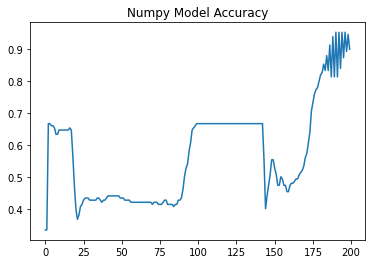

In [79]:
plt.plot(model.accuracy)
plt.title('Numpy Model Accuracy')

Text(0.5, 1.0, 'Numpy Model Loss')

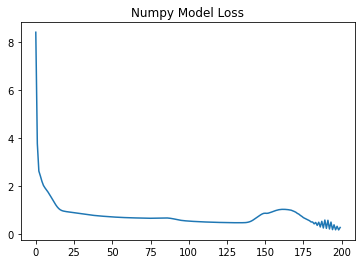

In [80]:
plt.plot(model.loss)
plt.title('Numpy Model Loss')

In [67]:
model = Network()
model.add(DenseLayer(6))
model.add(DenseLayer(8))
model.add(DenseLayer(10))
model.add(DenseLayer(3))

model.train(X, y, 200)

EPOCH: 0, ACCURACY: 0.3333333333333333, LOSS: 8.40744716505373
EPOCH: 20, ACCURACY: 0.4, LOSS: 0.9217739285797661
EPOCH: 40, ACCURACY: 0.43333333333333335, LOSS: 0.7513140371257646
EPOCH: 60, ACCURACY: 0.42, LOSS: 0.6686109548451099
EPOCH: 80, ACCURACY: 0.41333333333333333, LOSS: 0.6527102403575207
EPOCH: 100, ACCURACY: 0.6666666666666666, LOSS: 0.5264810434939678
EPOCH: 120, ACCURACY: 0.6666666666666666, LOSS: 0.4708499275871513
EPOCH: 140, ACCURACY: 0.6666666666666666, LOSS: 0.5035542867669844
EPOCH: 160, ACCURACY: 0.47333333333333333, LOSS: 1.0115020349485782
EPOCH: 180, ACCURACY: 0.82, LOSS: 0.49134888468425214


In [41]:
model.params[0]['W'].shape, list(reversed(model.gradients))[0]['dW'].shape

((6, 4), (4, 6))

In [165]:
print('PROBABILITY DISTRIBTION @ IDX 0:', out[0])
print('CORRECT CLASS @ IDX 0:', y[0])

out[0][0] = out[0][0]-1
print('d_probs:', out[0])

PROBABILITY DISTRIBTION @ IDX 0: [9.99998315e-01 1.07470169e-06 6.10266912e-07]
CORRECT CLASS @ IDX 0: 0
d_probs: [-1.68496861e-06  1.07470169e-06  6.10266912e-07]


In [154]:
d_out = out[0, y[0]] - 1
d_out

-1.6849686059750013e-06

In [125]:
print(model.params[0]['W'].shape, model.params[0]['b'].shape)
print(model.params[1]['W'].shape, model.params[1]['b'].shape)
print(model.params[2]['W'].shape, model.params[2]['b'].shape)
print(model.params[3]['W'].shape, model.params[3]['b'].shape)

(6, 4) (1, 6)
(8, 6) (1, 8)
(10, 8) (1, 10)
(3, 10) (1, 3)


In [20]:
model = Network()
model.add(DenseLayer(6))
model.add(DenseLayer(8))
model.add(DenseLayer(10))
model.add(DenseLayer(3))

model._init_weights(X)
out = model._forwardprop(X)

In [148]:
print('SHAPE:', out.shape)
print('Probabilties at idx 0:', out[0])
print('SUM:', sum(out[0]))

SHAPE: (150, 3)
Probabilties at idx 0: [9.99998315e-01 1.07470169e-06 6.10266912e-07]
SUM: 1.0


In [142]:
sum(out[0])

1.0

In [141]:
model.memory[3]['Z'][0]

array([ 8.97399717, -4.76946857, -5.33537056])

In [14]:
def backward(dA_curr, W_curr, Z_curr, A_prev, activation):
    if activation == 'softmax':
        dW = np.dot(A_prev.T, dA_curr)
        db = np.sum(dA_curr, axis=0, keepdims=True)
        dA = np.dot(dA_curr, W_curr) 
    else:
        dZ = relu_derivative(dA_curr, Z_curr)
        dW = np.dot(A_prev.T, dZ)
        db = np.sum(dZ, axis=0, keepdims=True)
        dA = np.dot(dZ, W_curr)

    return dA, dW, db

In [23]:
dA4, dW4, db4 = backward(dscores, model.params[3]['W'], model.memory[3]['Z'], model.memory[3]['inputs'], activation='softmax')
# dA3, dW3, db3 = backward(dA4, model.params[2]['W'], model.memory[2]['Z'], model.memory[2]['inputs'], activation='relu')
# dA2, dW2, db2 = backward(dA3, model.params[1]['W'], model.memory[1]['Z'], model.memory[1]['inputs'], activation='relu')
# dA1, dW1, db1 = backward(dA2, model.params[0]['W'], model.memory[0]['Z'], model.memory[0]['inputs'], activation='relu')

In [31]:
print(dA4[0])
print()
print(model.memory[2]['Z'][0])

[-3.43452010e-09 -5.90825642e-09 -1.19441329e-08 -1.35633938e-08
 -8.18994886e-09  5.46415451e-09  4.88397500e-09 -9.96250139e-09
 -1.11144493e-08  4.46874053e-10]

[ 3.70228403 -3.61384089 -4.90509341  4.56114398  3.37757782  3.10155643
  2.38419468 -0.23402421  7.49556206  0.61598379]


In [33]:
dA4[0]

array([-3.43452010e-09,  0.00000000e+00,  0.00000000e+00, -1.35633938e-08,
       -8.18994886e-09,  5.46415451e-09,  4.88397500e-09,  0.00000000e+00,
       -1.11144493e-08,  4.46874053e-10])

In [32]:
dA4[model.memory[2]['Z'] <= 0] = 0

In [24]:
dZ = np.array(dA4, copy = True)

In [26]:
dZ[model.memory[2]['Z'] <= 0] = 0

In [27]:
dZ

array([[-3.43452010e-09,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -1.11144493e-08,  4.46874053e-10],
       [-9.11767179e-09,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -2.72469787e-08,  2.38096815e-09],
       [-1.10962662e-08,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -3.50756647e-08,  1.88431867e-09],
       ...,
       [ 3.14249820e-03,  3.85202103e-03,  0.00000000e+00, ...,
         0.00000000e+00,  5.03148709e-03,  0.00000000e+00],
       [ 3.14246463e-03,  3.85194946e-03,  0.00000000e+00, ...,
         0.00000000e+00,  5.03133275e-03,  0.00000000e+00],
       [ 3.14245826e-03,  3.85192927e-03,  0.00000000e+00, ...,
         0.00000000e+00,  5.03128162e-03,  0.00000000e+00]])

In [12]:
model = Network()
model.add(DenseLayer(6))
model.add(DenseLayer(8))
model.add(DenseLayer(3))
# model.add(DenseLayer(10))
# model.add(DenseLayer(6))

model._init_weights(X)
out = model._forwardprop(X)

# model.train(X,y,200)

In [22]:
def relu_derivative(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

dscores = out
dscores[range(150),y] -= 1
dscores /= 150

In [127]:
correct_logprobs = -np.log(out[range(150),y])

In [40]:
ohy = tf.keras.utils.to_categorical(y, num_classes=3)

In [43]:
print(ohy[0])
print(out[0])

[1. 0. 0.]
[3.01929735e-07 7.83961013e-09 9.99999690e-01]


In [48]:
v1 = -np.log(out[0][0]) * ohy[0][0]
v2 = -np.log(out[0][1]) * ohy[0][1]
v3 = -np.log(out[0][2]) * ohy[0][2]
v1+v2+v3

15.01307151332731

In [52]:
print(correct_logprobs[0])
print(-np.log(out[0,0]))

15.01307151332731
15.01307151332731


In [85]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.optimizers import SGD

ohy = tf.keras.utils.to_categorical(y, num_classes=3)

model2 = Sequential()
model2.add(Dense(6, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(3, activation='softmax'))

model2.compile(SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

model2.fit(x=X, y=ohy, epochs=30)

Epoch 1/30
5/5 [==============================] - 0s 2ms/step - loss: 1.4516 - accuracy: 0.2733
Epoch 2/30
5/5 [==============================] - 0s 3ms/step - loss: 1.1326 - accuracy: 0.1400
Epoch 3/30
5/5 [==============================] - 0s 2ms/step - loss: 1.0596 - accuracy: 0.2867
Epoch 4/30
5/5 [==============================] - 0s 3ms/step - loss: 1.0201 - accuracy: 0.4933
Epoch 5/30
5/5 [==============================] - 0s 2ms/step - loss: 0.9906 - accuracy: 0.4400
Epoch 6/30
5/5 [==============================] - 0s 2ms/step - loss: 0.9610 - accuracy: 0.7000
Epoch 7/30
5/5 [==============================] - 0s 3ms/step - loss: 0.9296 - accuracy: 0.7400
Epoch 8/30
5/5 [==============================] - 0s 2ms/step - loss: 0.8928 - accuracy: 0.8000
Epoch 9/30
5/5 [==============================] - 0s 2ms/step - loss: 0.8601 - accuracy: 0.8067
Epoch 10/30
5/5 [==============================] - 0s 2ms/step - loss: 0.8255 - accuracy: 0.7800
Epoch 11/30
5/5 [======================

Text(0.5, 1.0, 'Keras Accuracy')

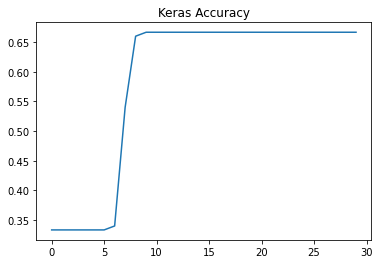

In [83]:
plt.plot(model2.history.history['accuracy'])
plt.title('Keras Accuracy')

Text(0.5, 1.0, 'Keras Loss')

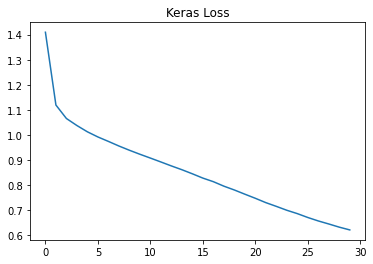

In [84]:
plt.plot(model2.history.history['loss'])
plt.title('Keras Loss')